In [11]:
import pandas as pd
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
import torch 
from matplotlib import pyplot as plt
import numpy as np
from maderapp.data.data_inference import MaderappDatasetInference
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

model_path = "maderapp-epoch=247-val_loss=0.05.ckpt"
model_name = "MobileNet"
num_classes = 27

In [12]:
def display_confusion_matrix(cmat, score, precision, recall, titlestring):
    plt.figure(figsize=(20,20))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(np.array(list(range(cmat.shape[0]))) + 1)
    ax.set_xticklabels(np.array(list(range(cmat.shape[0]))) + 1, fontdict={'fontsize': 18})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(np.array(list(range(cmat.shape[0]))) + 1)
    ax.set_yticklabels(np.array(list(range(cmat.shape[0]))) + 1, fontdict={'fontsize': 18})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    if score is not None:
        titlestring += '\n f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\n precision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\n recall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(32, 1, titlestring, fontdict={'fontsize': 30, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

In [13]:
metadata = pd.read_csv("../metadata-v3.csv", header=None)
metadata = metadata[metadata.iloc[:, 2] == 1]
class_names = sorted(metadata.iloc[:, 1].value_counts().index)
class_names2ids = {j: i for i, j in enumerate(class_names)}
class_ids2names = {j: i for i, j in class_names2ids.items()}


In [63]:
set(class_names2ids.keys())

27

In [10]:
ground_true = pd.read_csv("../images_validation_encoded.csv")
ground_true.head()

,real_path,made_path,label
0,Leche_Caspi/Leche_Caspi (678).jpg,0.jpg,Leche_Caspi
1,Oje/Oje (303).jpg,1.jpg,Oje
2,Cedro_Odorata/Cedro_Odorata (743).jpg,2.jpg,Cedro_Odorata
3,Pino_Chuncho/Pino_Chuncho (311).jpg,3.jpg,Pino_Chuncho
4,Sachapalta_Ocotea/Sacha_Ocotea (326).jpg,4.jpg,Sachapalta_Ocotea


In [18]:
transformation = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],),
        ToTensorV2(),
    ]
)

In [15]:
model = torch.jit.load("opt_trace_mobileNet-v3.pt")
data_path = "/Users/anvelezec/Downloads/validation_img"
metadata = [str(path) for path in list(Path(data_path).glob("*.jpg"))]

print(metadata[:10])
print(len(metadata))

['/Users/anvelezec/Downloads/validation_img/63.jpg', '/Users/anvelezec/Downloads/validation_img/823.jpg', '/Users/anvelezec/Downloads/validation_img/2100.jpg', '/Users/anvelezec/Downloads/validation_img/1409.jpg', '/Users/anvelezec/Downloads/validation_img/189.jpg', '/Users/anvelezec/Downloads/validation_img/2114.jpg', '/Users/anvelezec/Downloads/validation_img/77.jpg', '/Users/anvelezec/Downloads/validation_img/837.jpg', '/Users/anvelezec/Downloads/validation_img/usbcamera20220512114654.jpg', '/Users/anvelezec/Downloads/validation_img/1353.jpg']
2740


In [37]:
if False:
    with open("images_validation_encoded.csv", "a") as file:
        for file_name in metadata:
            file_name = file_name.split("/")[-1]
            file.writelines(f"{None},{file_name},Bolaina\n")

In [16]:
ground_true_pos = ground_true.iloc[:, 1].tolist()
ground_true_pos = [item.strip() for item in ground_true_pos]

ground_true_items = []
for item in metadata:
    print(item)
    item = item.split("/")[-1]
    ground_true_item = ground_true.iloc[ground_true_pos.index(item), 2]
    ground_true_item = ground_true_item.strip()
    ground_true_items.append(ground_true_item)

ground_true_items[:10]

/Users/anvelezec/Downloads/validation_img/63.jpg
/Users/anvelezec/Downloads/validation_img/823.jpg
/Users/anvelezec/Downloads/validation_img/2100.jpg
/Users/anvelezec/Downloads/validation_img/1409.jpg
/Users/anvelezec/Downloads/validation_img/189.jpg
/Users/anvelezec/Downloads/validation_img/2114.jpg
/Users/anvelezec/Downloads/validation_img/77.jpg
/Users/anvelezec/Downloads/validation_img/837.jpg
/Users/anvelezec/Downloads/validation_img/usbcamera20220512114654.jpg
/Users/anvelezec/Downloads/validation_img/1353.jpg
/Users/anvelezec/Downloads/validation_img/1435.jpg
/Users/anvelezec/Downloads/validation_img/2128.jpg
/Users/anvelezec/Downloads/validation_img/1421.jpg
/Users/anvelezec/Downloads/validation_img/1347.jpg
/Users/anvelezec/Downloads/validation_img/638.jpg
/Users/anvelezec/Downloads/validation_img/1390.jpg
/Users/anvelezec/Downloads/validation_img/604.jpg
/Users/anvelezec/Downloads/validation_img/162.jpg
/Users/anvelezec/Downloads/validation_img/176.jpg
/Users/anvelezec/Downlo

['Tornillo',
 'Yarahuisca',
 'Palo_Verde',
 'Moena_Amarilla',
 'Pochotoraque',
 'Sachapalta_Hymenopus',
 'Palo_Azufre',
 'Copaiba',
 'Bolaina',
 'Tulpay']

In [19]:
ds = MaderappDatasetInference(annotations_file=metadata, transform=transformation)
dl = DataLoader(ds, batch_size=30, shuffle=False, num_workers=4)

In [20]:
preds = []
for x, y in iter(dl):
    y_pred = model(x)
    class_pred = [class_ids2names[int(idx)] for idx in y_pred.argmax(dim=1)]
    preds.extend(class_pred)

/opt/anaconda3/envs/pt-lightnin/lib/python3.8/site-packages/torch/nn/modules/module.py:1102: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1408.)
  return forward_call(*input, **kwargs)


In [67]:

cm = confusion_matrix(y_true=ground_true_items, y_pred=preds, labels=list(class_names2ids.keys()))

# F1 score - Presicion - Recall
score = f1_score(ground_true_items, preds, average='macro')
precision = precision_score(ground_true_items, preds, average='macro')
recall = recall_score(ground_true_items, preds, average='macro')

#cm = (cm.T / cm.sum(axis=1)).T 

/var/folders/cm/v8nztt8j1xvgr37g1sg8xg180000gn/T/ipykernel_7609/6262811.py:8: RuntimeWarning: invalid value encountered in true_divide
  cm = (cm.T / cm.sum(axis=1)).T


In [69]:
import pandas as pd
pd.DataFrame(cm).to_csv("cm.csv")

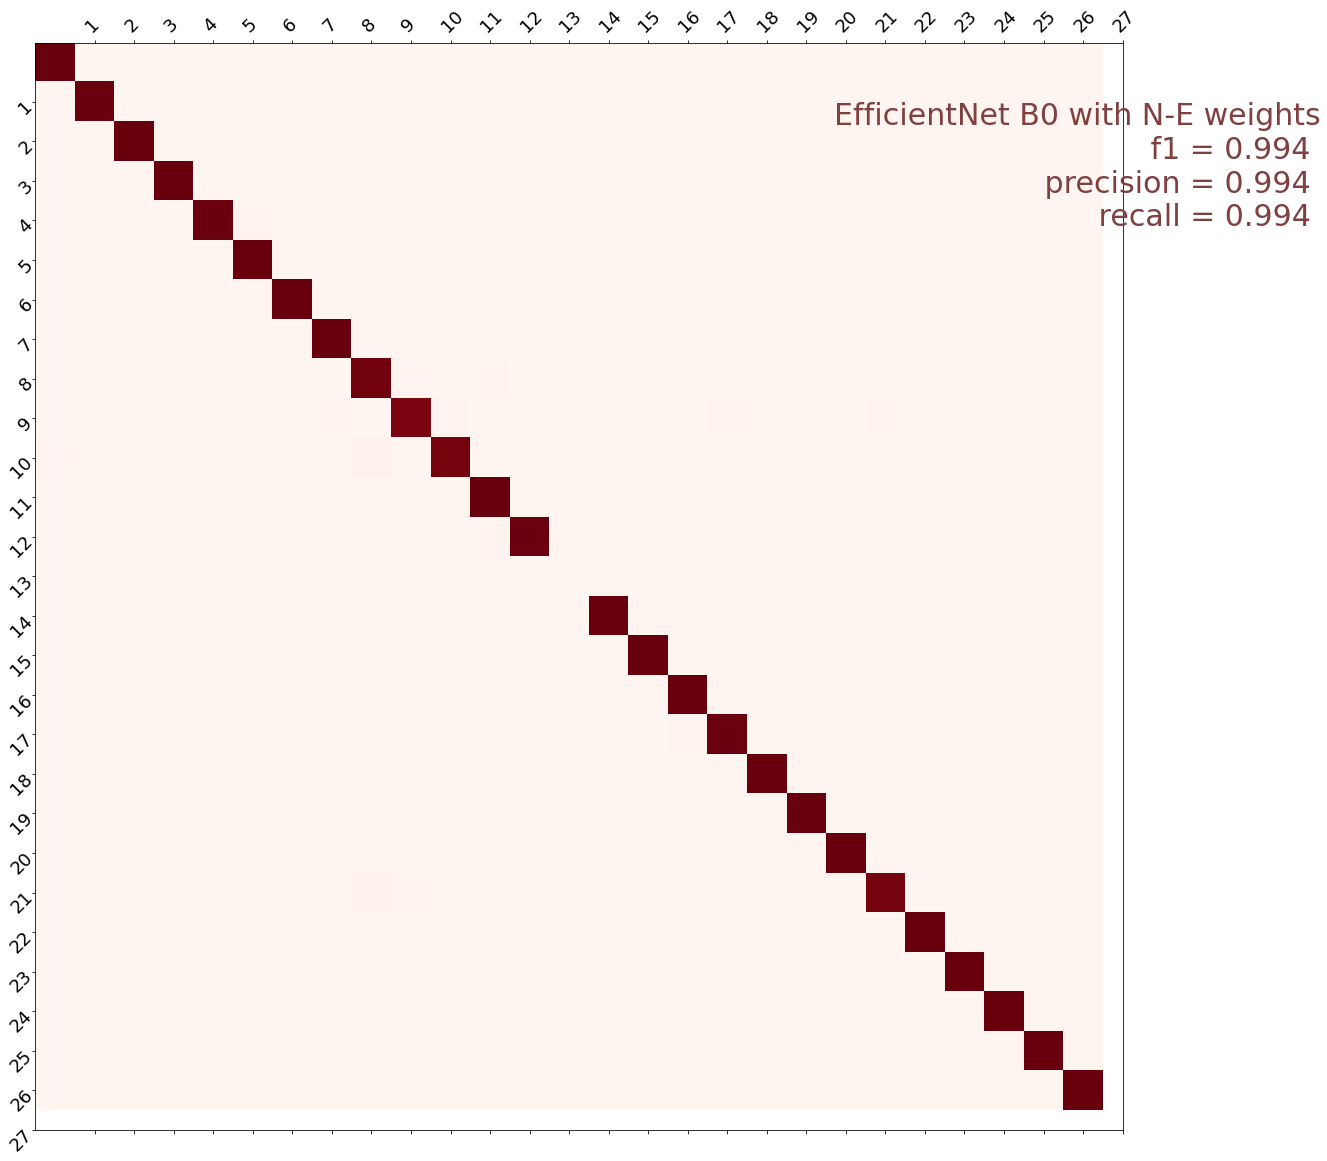

f1 score: 0.994, precision: 0.994, recall: 0.994


In [48]:
titlestring = "EfficientNet B0 with N-E weights"

display_confusion_matrix(cm, score, precision, recall, titlestring)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))